In [1]:
import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from UnFaIR import *
import scipy as sp

In [17]:
## I think a neat figure would potentially be an exploration of parameter space?

## Get all the data

## Get Law Dome

Law_Dome = pd.read_csv('./Conc_fit_data/law2006.txt',index_col=0,skiprows=183,nrows=2188-184,delim_whitespace=True,usecols=[0,3,5,8],names=['Year','CH4','CO2','N2O'])

# Get NOAA atmospheric observations

obsv_concs = pd.read_csv('./Conc_fit_data/NOAA_Conc_data.csv',skiprows=4,header=None,index_col=0).dropna().iloc[:,:3].values
obsv_concs = pd.DataFrame(data=obsv_concs,index = np.arange(1979,2018),columns=['CO2','CH4','N2O'])

N2O_ems_1890_1990 = pd.read_csv('./Conc_fit_data/edgar_hyde1.4-glob_n2o.csv',index_col=0)
N2O_ems_1970_2012 = pd.read_csv('./Conc_fit_data/v432_N2O_1970_2012.csv',index_col=0)

CH4_ems_1850_2014 = pd.read_csv('./Conc_fit_data/CEDS_CH4_global_emissions_1850_2014.csv',index_col=0,names=['Year','CH4'])
CO2_ems_1750_2014 = pd.read_csv('./Conc_fit_data/CEDS_CO2_global_emissions_1750_2014.csv',index_col=0,names=['Year','CO2'])*(12/44)

RCP6_E = pd.read_csv('./RCP_data/RCP6_EMISSIONS.csv',skiprows=36,index_col=0)
RCP_ems = pd.DataFrame(data = np.array([RCP6_E[['OtherCO2','FossilCO2']].sum(axis=1).values,RCP6_E['CH4'].values,RCP6_E['N2O'].values]).T,columns=['CO2','CH4','N2O'],index = RCP6_E.index)

## Now we need to harmonise the datasets to get a full 1765 - 2015 run

N2O_ems_1890_1970_vals = (N2O_ems_1890_1990.loc[range(1890,1970)] * N2O_ems_1970_2012.loc[1970] / N2O_ems_1890_1990.loc[1970]).values.flatten()
N2O_ems_1765_1890_vals = (RCP_ems.N2O.loc[range(1765,1890)] * N2O_ems_1890_1970_vals[0] / RCP_ems.N2O.loc[1890]).values
N2O_ems_1970_2012_vals = N2O_ems_1970_2012.values.flatten()

N2O_ems_1765_2012 = pd.DataFrame(np.concatenate((N2O_ems_1765_1890_vals,N2O_ems_1890_1970_vals,N2O_ems_1970_2012_vals)),columns=['N2O'],index = np.arange(1765,2013))
N2O_ems_1765_2012 = N2O_ems_1765_2012.interpolate(method='linear',axis=0)


CH4_ems_1850_2014_vals = CH4_ems_1850_2014.drop_duplicates().values.flatten()
CH4_ems_1765_1850_vals = (RCP_ems.CH4.loc[range(1765,1850)] * CH4_ems_1850_2014_vals[0] / RCP_ems.CH4.loc[1850]).values.flatten()

CH4_ems_1765_2014 = pd.DataFrame(np.concatenate((CH4_ems_1765_1850_vals,CH4_ems_1850_2014_vals)),columns=['CH4'],index = np.arange(1765,2015))

CO2_ems_1765_2014 = CO2_ems_1750_2014.loc[1765:] ## Not including OtherCO2 for now? CEDS seems to be fossil co2

emissions = (CO2_ems_1765_2014+pd.DataFrame(data=RCP85_E.OtherCO2.loc[:2014].values,columns=['CO2'],index=CO2_ems_1765_2014.index)).copy()
emissions['CH4'] = CH4_ems_1765_2014
emissions['N2O'] = N2O_ems_1765_2012
emissions['N2O'].loc[2013] = 2*emissions['N2O'].loc[2012] - emissions['N2O'].loc[2011]
emissions['N2O'].loc[2014] = 2*emissions['N2O'].loc[2013] - emissions['N2O'].loc[2012]
emissions['N2O'] = emissions['N2O']*6.6 / emissions.N2O.loc[2010]

emissions = emissions.append(RCP_ems.loc[2015:] - RCP_ems.loc[2014] + emissions.loc[2014])

/home/nleach/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


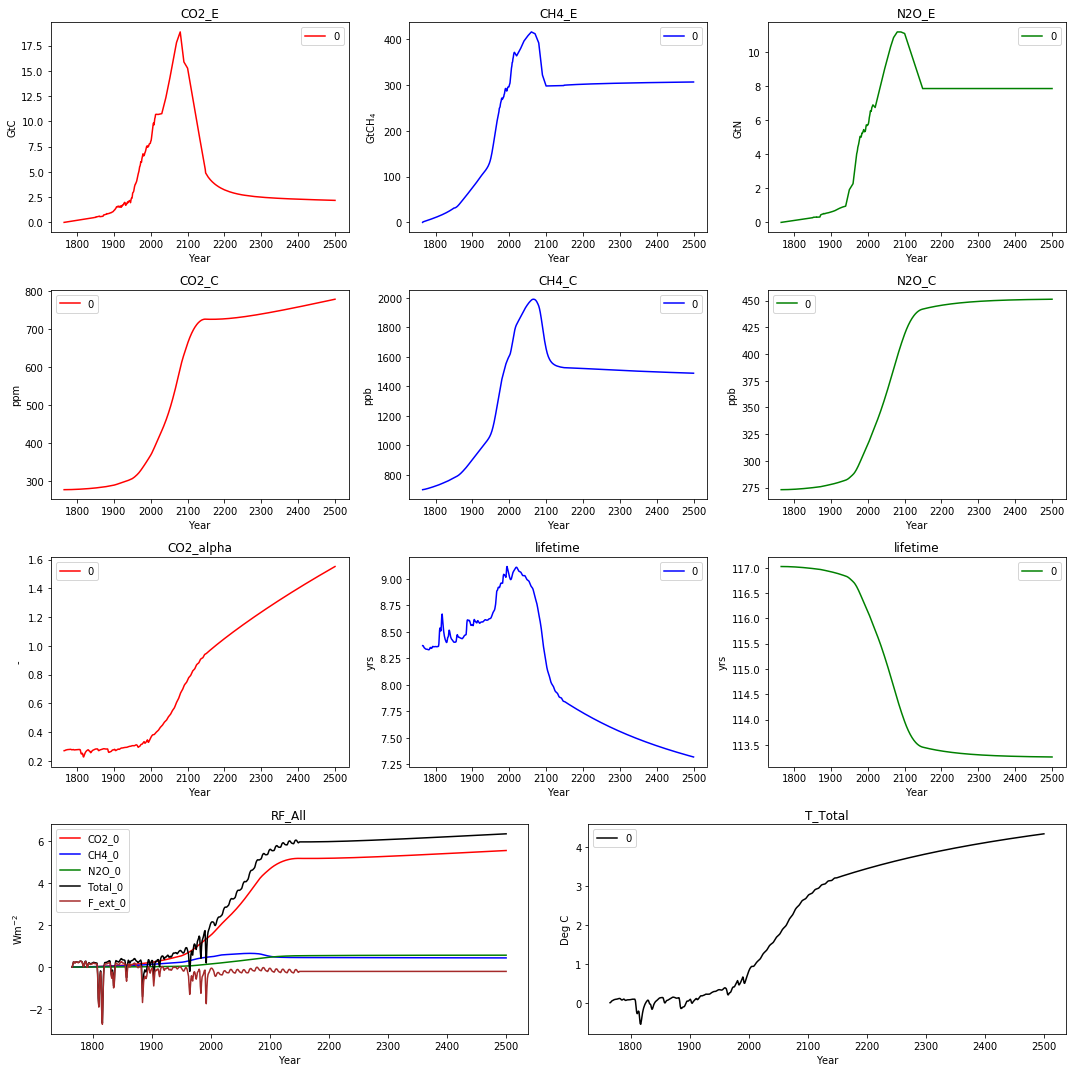

In [45]:
## Get an "other" forcing dataset:
RCP6_forc = pd.read_csv('./Conc_fit_data/RCP6_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)
otherforc = RCP6_forc.TOTAL_INCLVOLCANIC_RF.values - RCP6_forc.CO2CH4N2O_RF.values

plot_all([UnFaIR(emissions,otherforc)])

In [39]:
one_cow_methane_year = 370 * 365/ 10**12

Nicks_cow = pd.DataFrame(data = np.full(20,one_cow_methane_year),index = np.arange(2019,2039),columns=['CH4'])

In [40]:
Nicks_cow['CO2'] = 0
Nicks_cow['N2O'] = 0

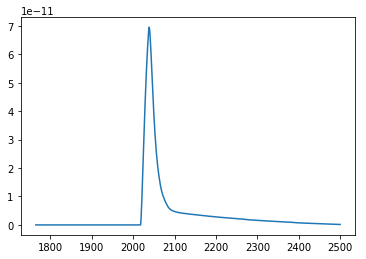

In [51]:
cow_emissions = emissions.add(Nicks_cow,fill_value=0)[['CO2','CH4','N2O']]

T_with_cow = UnFaIR(cow_emissions,otherforc)
T_without = UnFaIR(emissions,otherforc)

(T_with_cow['T']['Total'] - T_without['T']['Total']).plot()